# Подбор оптимальных поргов для моделей

## Подгрузка необходимых библиотек

In [3]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:.3f}'.format
random.seed(42)
np.random.seed(42)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

import optuna
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, auc

from functools import partial
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


## Данные

In [5]:
df = pd.read_csv('/Users/inreleppik/githubr/toxic-comments-classification/modified_train.csv',
                 parse_dates=['created_date'], date_format='ISO8601')
# Удаление из данных отрезков времени, в которых слишком мало данных
df = df[df['created_date'] >= '2016-04-01']
# Сортировка данных для дальнейшего разделения по временной метке для дальнейшего деления на train/val/test
df = df.sort_values('created_date').reset_index(drop=True)
# Заполнение N/A значений в обработанных комментариях без стоп слов
df['ctws'] = df['ctws'].fillna('')
# Размерность данных 
print(f'Dataset shape: {df.shape}')
print(f'Dataset (Only ordinary class) shape: {df[df.toxicity_b == 0].shape}')
print(f'Dataset (Only toxic class) shape: {df[df.toxicity_b == 1].shape}')
print('Процентное соотношение значений ' + str(df['toxicity_b'].value_counts(normalize=True) * 100))

Dataset shape: (1785308, 39)
Dataset (Only ordinary class) shape: (1585541, 39)
Dataset (Only toxic class) shape: (199767, 39)
Процентное соотношение значений toxicity_b
0   88.811
1   11.189
Name: proportion, dtype: float64


### Подготовка данных

In [9]:
split_date = df.iloc[int(len(df) * 0.8)]['created_date']
train_val_df = df[df['created_date'] <= split_date]
test_df = df[df['created_date'] > split_date]
X_test = test_df['ctws']
y_test = test_df['toxicity_b']

In [11]:
split_date = train_val_df.iloc[int(len(train_val_df) * 0.8)]['created_date']
train_df = train_val_df[train_val_df['created_date'] <= split_date]
val_df = train_val_df[train_val_df['created_date'] > split_date]

X_train = train_df['ctws']
y_train = train_df['toxicity_b']
X_val = val_df['ctws']
y_val= val_df['toxicity_b']

In [13]:
y_train.mean(), y_test.mean(), y_val.mean()

(0.10893507602848947, 0.11765776716023313, 0.11653112736260235)

### Функции для обучения и анализа

In [16]:
def train_and_predict_toxicity(model, X_train, X_val, X_test, y_train):
    model.fit(X_train, y_train)

    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    y_pred_test = model.predict(X_test)

    if hasattr(model, 'predict_proba'):
        # Вероятности для положительного класса
        y_pred_proba_train = model.predict_proba(X_train)[:, 1]
        y_pred_proba_val = model.predict_proba(X_val)[:, 1]
        y_pred_proba_test = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, 'decision_function'):
        y_pred_proba_train = model.decision_function(X_train)
        y_pred_proba_val = model.decision_function(X_val)
        y_pred_proba_test = model.decision_function(X_test)
    else:
        y_pred_proba_train = None
        y_pred_proba_val = None
        y_pred_proba_test = None

    return y_pred_train, y_pred_val, y_pred_test, y_pred_proba_train, y_pred_proba_val, y_pred_proba_test

# Функция для отображения метрик
def show_metrics(y_train, y_val, y_test, y_pred_train, y_pred_val, y_pred_test, y_pred_proba_train, y_pred_proba_val, y_pred_proba_test, title):
    precision_train = precision_score(y_train, y_pred_train)
    precision_val = precision_score(y_val, y_pred_val)
    precision_test = precision_score(y_test, y_pred_test)

    recall_train = recall_score(y_train, y_pred_train)
    recall_val = recall_score(y_val, y_pred_val)
    recall_test = recall_score(y_test, y_pred_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_val = f1_score(y_val, y_pred_val)
    f1_test = f1_score(y_test, y_pred_test)

    print(title + '\n')

    print('Precision\t\tRecall\t\t\tF1\n')
    print(f'Train: {precision_train:.2f}\t\tTrain: {recall_train:.2f}\t\tTrain: {f1_train:.2f}')
    print(f'Val: {precision_val:.2f}\t\tVal: {recall_val:.2f}\t\tVal: {f1_val:.2f}')
    print(f'Test: {precision_test:.2f}\t\tTest: {recall_test:.2f}\t\tTest: {f1_test:.2f}')

    def show_confusion_matrix(y_true, y_pred, sample_name, ax):
        cm = confusion_matrix(y_true, y_pred, normalize='all')
        labels = ['Non-Toxic (0)', 'Toxic (1)']
        cm_df = pd.DataFrame(cm, index=labels, columns=labels)
        
        sns.heatmap(cm_df, annot=True, fmt=".2%", cmap='twilight_shifted', ax=ax)
        ax.set_title(f'Confusion matrix ({sample_name})')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    def show_roc_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        auc = roc_auc_score(y_true, y_pred_proba)

        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.set_title(f'{model_name} ({sample_name}) ROC (AUC = {auc:.2f})')
        ax.grid(True)
    
    def show_pr_curve(y_true, y_pred_proba, model_name, sample_name, ax):
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        auc_pr = auc(recall, precision)

        ax.plot(recall, precision)
        ax.set_xlabel('Recall')
        ax.set_ylabel('Precision')
        ax.set_title(f'{model_name} ({sample_name}) Precision-Recall Curve (AUC = {auc_pr:.2f})')
        ax.grid(True)

    if y_pred_proba_train is not None and y_pred_proba_test is not None:
        _, axs = plt.subplots(3, 3, figsize=(18, 16))
        
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0, 0])
        show_confusion_matrix(y_val, y_pred_val, 'Val', axs[0, 1])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[0, 2])

        show_roc_curve(y_train, y_pred_proba_train, title, 'Train', axs[1, 0])
        show_roc_curve(y_val, y_pred_proba_val, title, 'Val', axs[1, 1])
        show_roc_curve(y_test, y_pred_proba_test, title, 'Test', axs[1, 2])

        show_pr_curve(y_train, y_pred_proba_train, title, 'Train', axs[2, 0])
        show_pr_curve(y_val, y_pred_proba_val, title, 'Val', axs[2, 1])
        show_pr_curve(y_test, y_pred_proba_test, title, 'Test', axs[2, 2])
    else:
        _, axs = plt.subplots(1, 3, figsize=(14, 6))
        
        show_confusion_matrix(y_train, y_pred_train, 'Train', axs[0])
        show_confusion_matrix(y_val, y_pred_val, 'Val', axs[1])
        show_confusion_matrix(y_test, y_pred_test, 'Test', axs[2])

    plt.tight_layout()
    plt.show()

In [18]:
from sklearn.decomposition import TruncatedSVD

def get_bows(X_train, X_val, X_test, ngram_range=(1, 1)):
    vec = CountVectorizer(ngram_range=ngram_range)
    vec.fit(X_train)
    X_train_bow = vec.transform(X_train)
    X_val_bow = vec.transform(X_val)
    X_test_bow = vec.transform(X_test)
    
    scaler = MaxAbsScaler()
    X_train_bow = scaler.fit_transform(X_train_bow)
    X_val_bow = scaler.transform(X_val_bow)
    X_test_bow = scaler.transform(X_test_bow)
    
    return X_train_bow, X_val_bow, X_test_bow

def get_tfidf(X_train, X_val, X_test, ngram_range=(1, 1)):
    vec = TfidfVectorizer(ngram_range=ngram_range, min_df=0.0001)
    X_train_tfidf = vec.fit_transform(X_train)
    X_val_tfidf = vec.transform(X_val)
    X_test_tfidf = vec.transform(X_test)

    scaler = MaxAbsScaler()
    X_train_tfidf = scaler.fit_transform(X_train_tfidf)
    X_val_tfidf = scaler.transform(X_val_tfidf)
    X_test_tfidf = scaler.transform(X_test_tfidf)
    
    return X_train_tfidf, X_val_tfidf, X_test_tfidf

In [20]:
def get_hyperparams(X_train, X_val, y_train, y_val, objective_func, n_trials=50):
    study = optuna.create_study(direction='maximize')
    study.optimize(partial(
        objective_func,
        X_train=X_train, X_val=X_val,
        y_train=y_train, y_val=y_val
    ), n_trials=n_trials)
    
    return study.best_params

In [9]:
X_val

1142598                       present truth church need hear
1142599    medium whitewash story compare arar settlement...
1142600    tebow throw tds per pas attempt man man would ...
1142601                                      set run govenor
1142602    delete button previous post poster texts inter...
                                 ...                        
1428242    well appear majority people want build levy pa...
1428243    probably skico post valid brownback cut fundin...
1428244    read article opening line recently speak music...
1428245                                                 know
1428246    think people understand go mind player time os...
Name: ctws, Length: 285649, dtype: object

## Обучение

### Logistic Regression BoW

In [22]:
X_train_bow, X_val_bow, X_test_bow = get_bows(X_train, X_val, X_test)

In [70]:
def logreg_objective(trial, X_train, X_val, y_train, y_val):

    # Оптимизируем гиперпараметры логистической регрессии
    C = trial.suggest_float("C", 1e-5, 10.0, log=True)  # Регуляризация
    max_iter = trial.suggest_int('max_iter', 500, 5000)

    lr = LogisticRegression(C=C, max_iter = max_iter, class_weight='balanced', n_jobs=10)
    lr.fit(X_train, y_train)
    y_pred_proba = lr.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [78]:
best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, logreg_objective, n_trials=20)
(
    y_log_reg_bow_pred_train,
    y_log_reg_bow_pred_val,
    y_log_reg_bow_pred_test,
    y_log_reg_bow_pred_proba_train,
    y_log_reg_bow_pred_proba_val,
    y_log_reg_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(**best_params, class_weight='balanced', n_jobs=10),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-02-18 22:54:32,531] A new study created in memory with name: no-name-f4be7a7e-a077-482b-907d-a5de61b66ab5
[I 2025-02-18 22:54:40,690] Trial 0 finished with value: 0.6551153032346119 and parameters: {'C': 0.20147100506142637, 'max_iter': 4966}. Best is trial 0 with value: 0.6551153032346119.
[I 2025-02-18 22:54:47,057] Trial 1 finished with value: 0.6603626938196905 and parameters: {'C': 1.3419561863283591, 'max_iter': 4712}. Best is trial 1 with value: 0.6603626938196905.
[I 2025-02-18 22:55:01,851] Trial 2 finished with value: 0.6615668933864853 and parameters: {'C': 1.687765691891837, 'max_iter': 3266}. Best is trial 2 with value: 0.6615668933864853.
[I 2025-02-18 22:55:03,151] Trial 3 finished with value: 0.45986514072163537 and parameters: {'C': 2.684893406271361e-05, 'max_iter': 2332}. Best is trial 2 with value: 0.6615668933864853.
[I 2025-02-18 22:55:04,713] Trial 4 finished with value: 0.49659704039135066 and parameters: {'C': 0.0009636863066950368, 'max_iter': 1023}. B

LogisticRegression BoW

Precision		Recall			F1

Train: 0.56		Train: 0.87		Train: 0.68
Val: 0.51		Val: 0.78		Val: 0.62
Test: 0.52		Test: 0.78		Test: 0.63


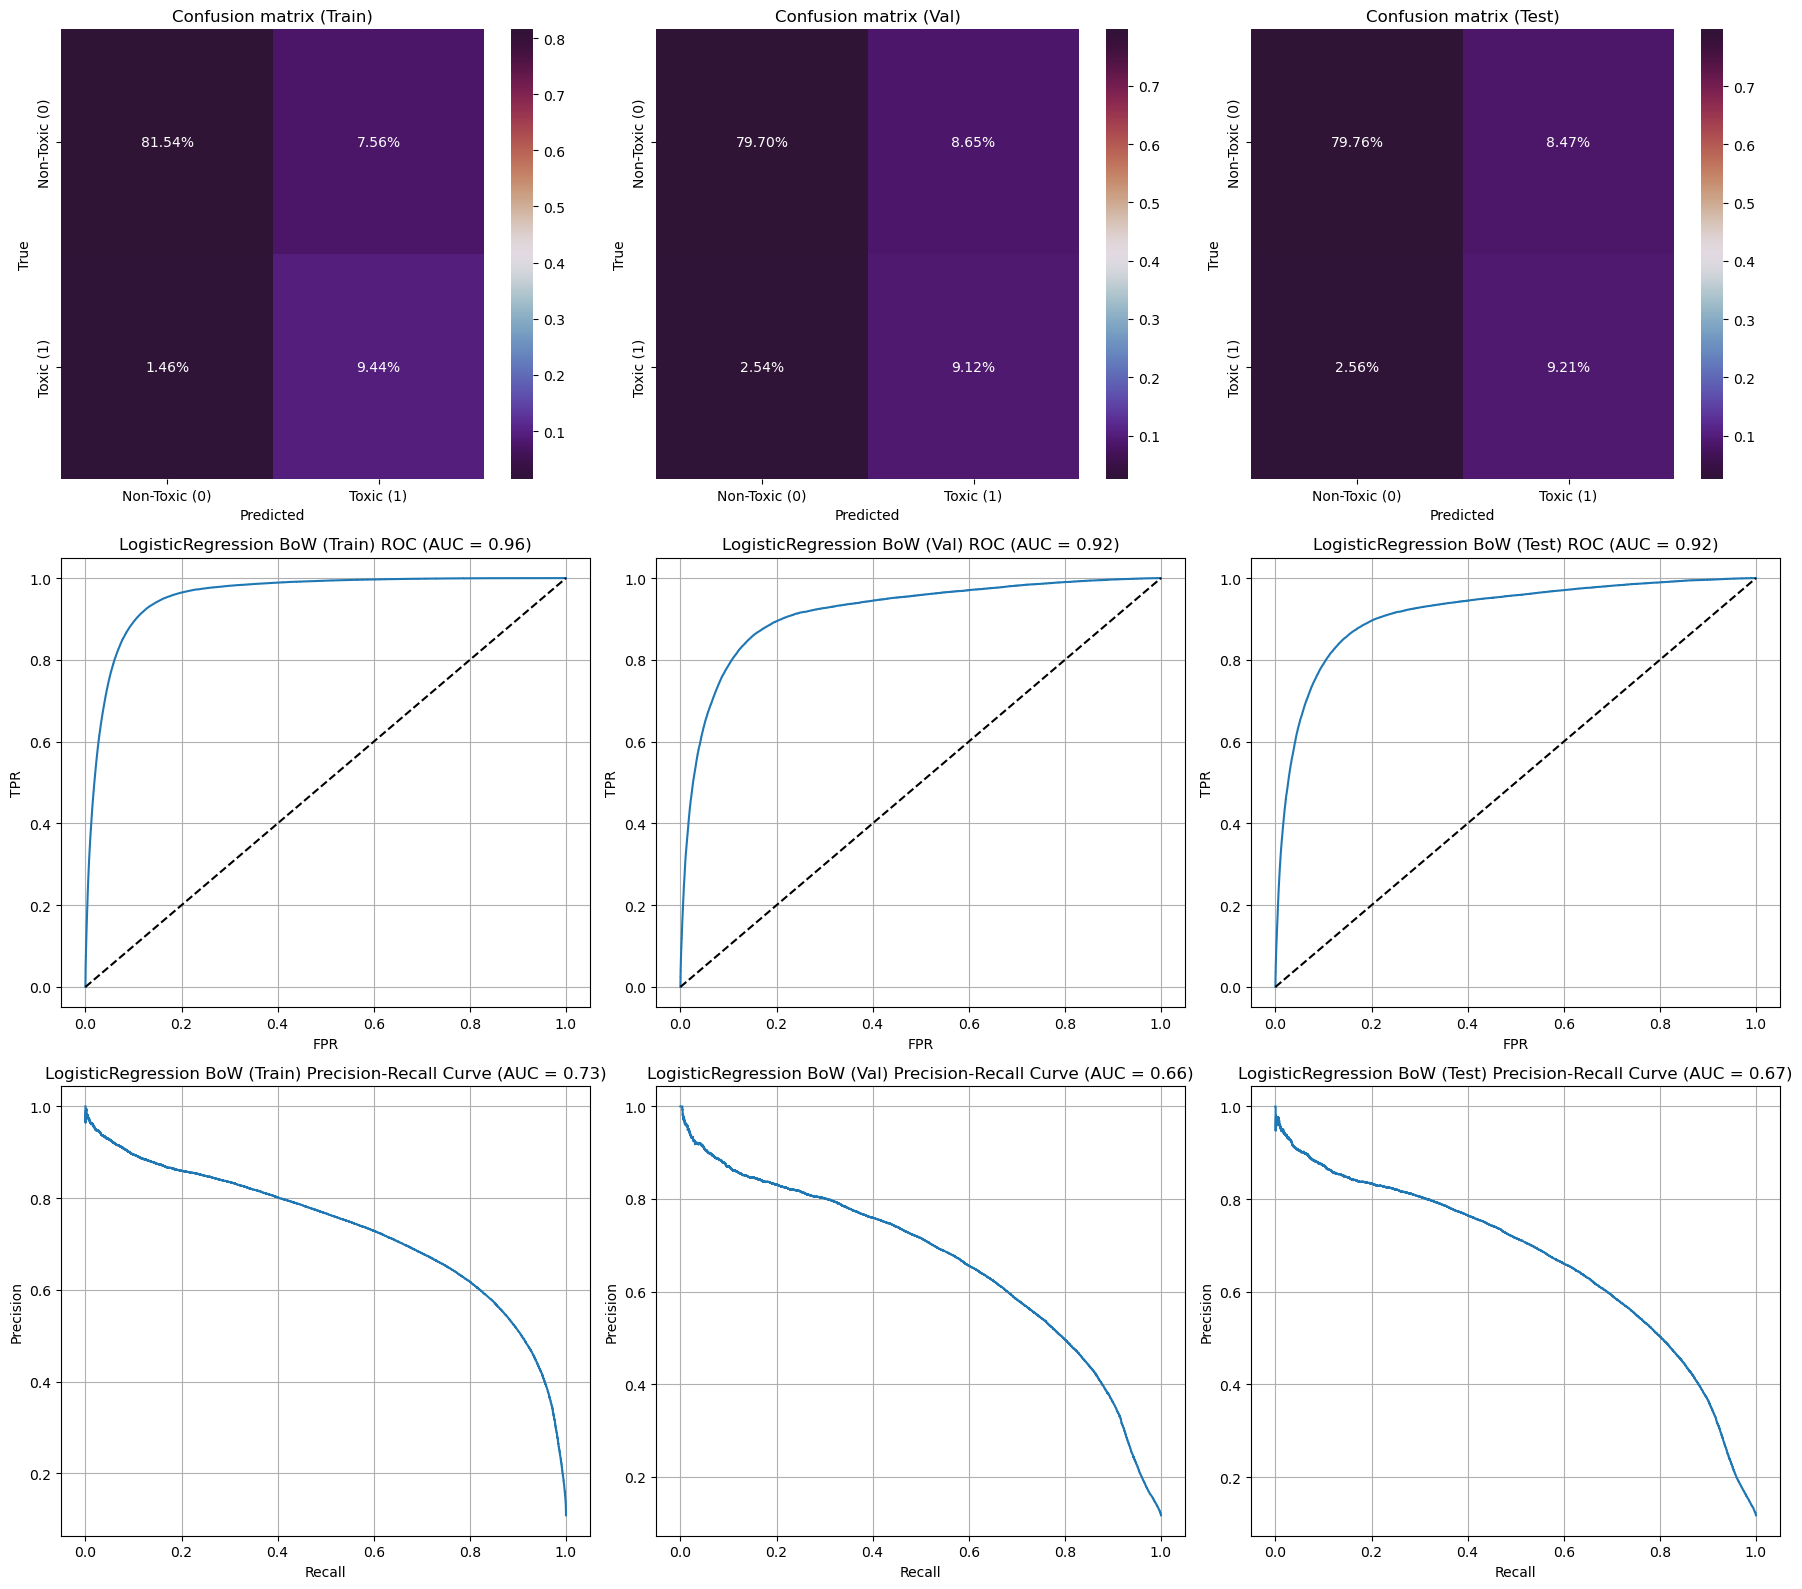

In [79]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_bow_pred_train,
    y_pred_val=y_log_reg_bow_pred_val,
    y_pred_test=y_log_reg_bow_pred_test,
    y_pred_proba_train=y_log_reg_bow_pred_proba_train,
    y_pred_proba_val=y_log_reg_bow_pred_proba_val,
    y_pred_proba_test=y_log_reg_bow_pred_proba_test,
    title='LogisticRegression BoW'
)

#### Побор порога вероятности

Создадим дата фрейм, в котором разместим метрики по разным порогам вероятности токсичного класса

In [97]:
metrics_data_val = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.001, 1.001, 0.001):
    p = precision_score(y_val, np.where(y_log_reg_bow_pred_proba_val > i, 1, 0))
    r = recall_score(y_val, np.where(y_log_reg_bow_pred_proba_val > i, 1, 0))
    f = f1_score(y_val, np.where(y_log_reg_bow_pred_proba_val > i, 1, 0))
    metrics_data_val.loc[len(metrics_data_val)] = [i, p, r, f]

In [110]:
metrics_data_val[metrics_data_val['f-1'] == metrics_data_val['f-1'].max()]

,threshold,precision,recall,f-1
679,0.680,0.607,0.672,0.638


In [134]:
metrics_data_val[metrics_data_val.threshold == 0.66]

,threshold,precision,recall,f-1
659,0.660,0.597,0.683,0.637


In [114]:
metrics_data_test = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.001, 1.001, 0.001):
    p = precision_score(y_test, np.where(y_log_reg_bow_pred_proba_test > i, 1, 0))
    r = recall_score(y_test, np.where(y_log_reg_bow_pred_proba_test > i, 1, 0))
    f = f1_score(y_test, np.where(y_log_reg_bow_pred_proba_test > i, 1, 0))
    metrics_data_test.loc[len(metrics_data_test)] = [i, p, r, f]

In [115]:
metrics_data_test[metrics_data_test['f-1'] == metrics_data_test['f-1'].max()]

,threshold,precision,recall,f-1
656,0.657,0.602,0.688,0.642


In [132]:
metrics_data_test[metrics_data_test.threshold == 0.66]

,threshold,precision,recall,f-1
659,0.660,0.603,0.686,0.642


### Logistic Regression TF-IDF

In [48]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = get_tfidf(X_train, X_val, X_test)

In [20]:
X_train_tfidf

<1142598x7118 sparse matrix of type '<class 'numpy.float64'>'
	with 24390281 stored elements in Compressed Sparse Row format>

In [138]:
best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, logreg_objective, n_trials=20)
(
    y_log_reg_tfidf_pred_train,
    y_log_reg_tfidf_pred_val,
    y_log_reg_tfidf_pred_test,
    y_log_reg_tfidf_pred_proba_train,
    y_log_reg_tfidf_pred_proba_val,
    y_log_reg_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=LogisticRegression(**best_params, class_weight='balanced', n_jobs=10),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-02-18 23:29:23,928] A new study created in memory with name: no-name-b464f1b5-e4ff-4ad2-a455-127558ba3439
[I 2025-02-18 23:29:27,462] Trial 0 finished with value: 0.7066305214319306 and parameters: {'C': 0.1986037771090595, 'max_iter': 2366}. Best is trial 0 with value: 0.7066305214319306.
[I 2025-02-18 23:29:28,732] Trial 1 finished with value: 0.44786887934756303 and parameters: {'C': 5.2987676873275555e-05, 'max_iter': 4469}. Best is trial 0 with value: 0.7066305214319306.
[I 2025-02-18 23:29:32,758] Trial 2 finished with value: 0.7161569042476215 and parameters: {'C': 6.173880568114795, 'max_iter': 4141}. Best is trial 2 with value: 0.7161569042476215.
[I 2025-02-18 23:29:36,450] Trial 3 finished with value: 0.681642283454974 and parameters: {'C': 0.03949101262094811, 'max_iter': 1231}. Best is trial 2 with value: 0.7161569042476215.
[I 2025-02-18 23:29:40,755] Trial 4 finished with value: 0.698555931948787 and parameters: {'C': 0.09978553397818248, 'max_iter': 3498}. Best 

LogisticRegression TF-IDF

Precision		Recall			F1

Train: 0.48		Train: 0.84		Train: 0.61
Val: 0.47		Val: 0.82		Val: 0.60
Test: 0.48		Test: 0.83		Test: 0.61


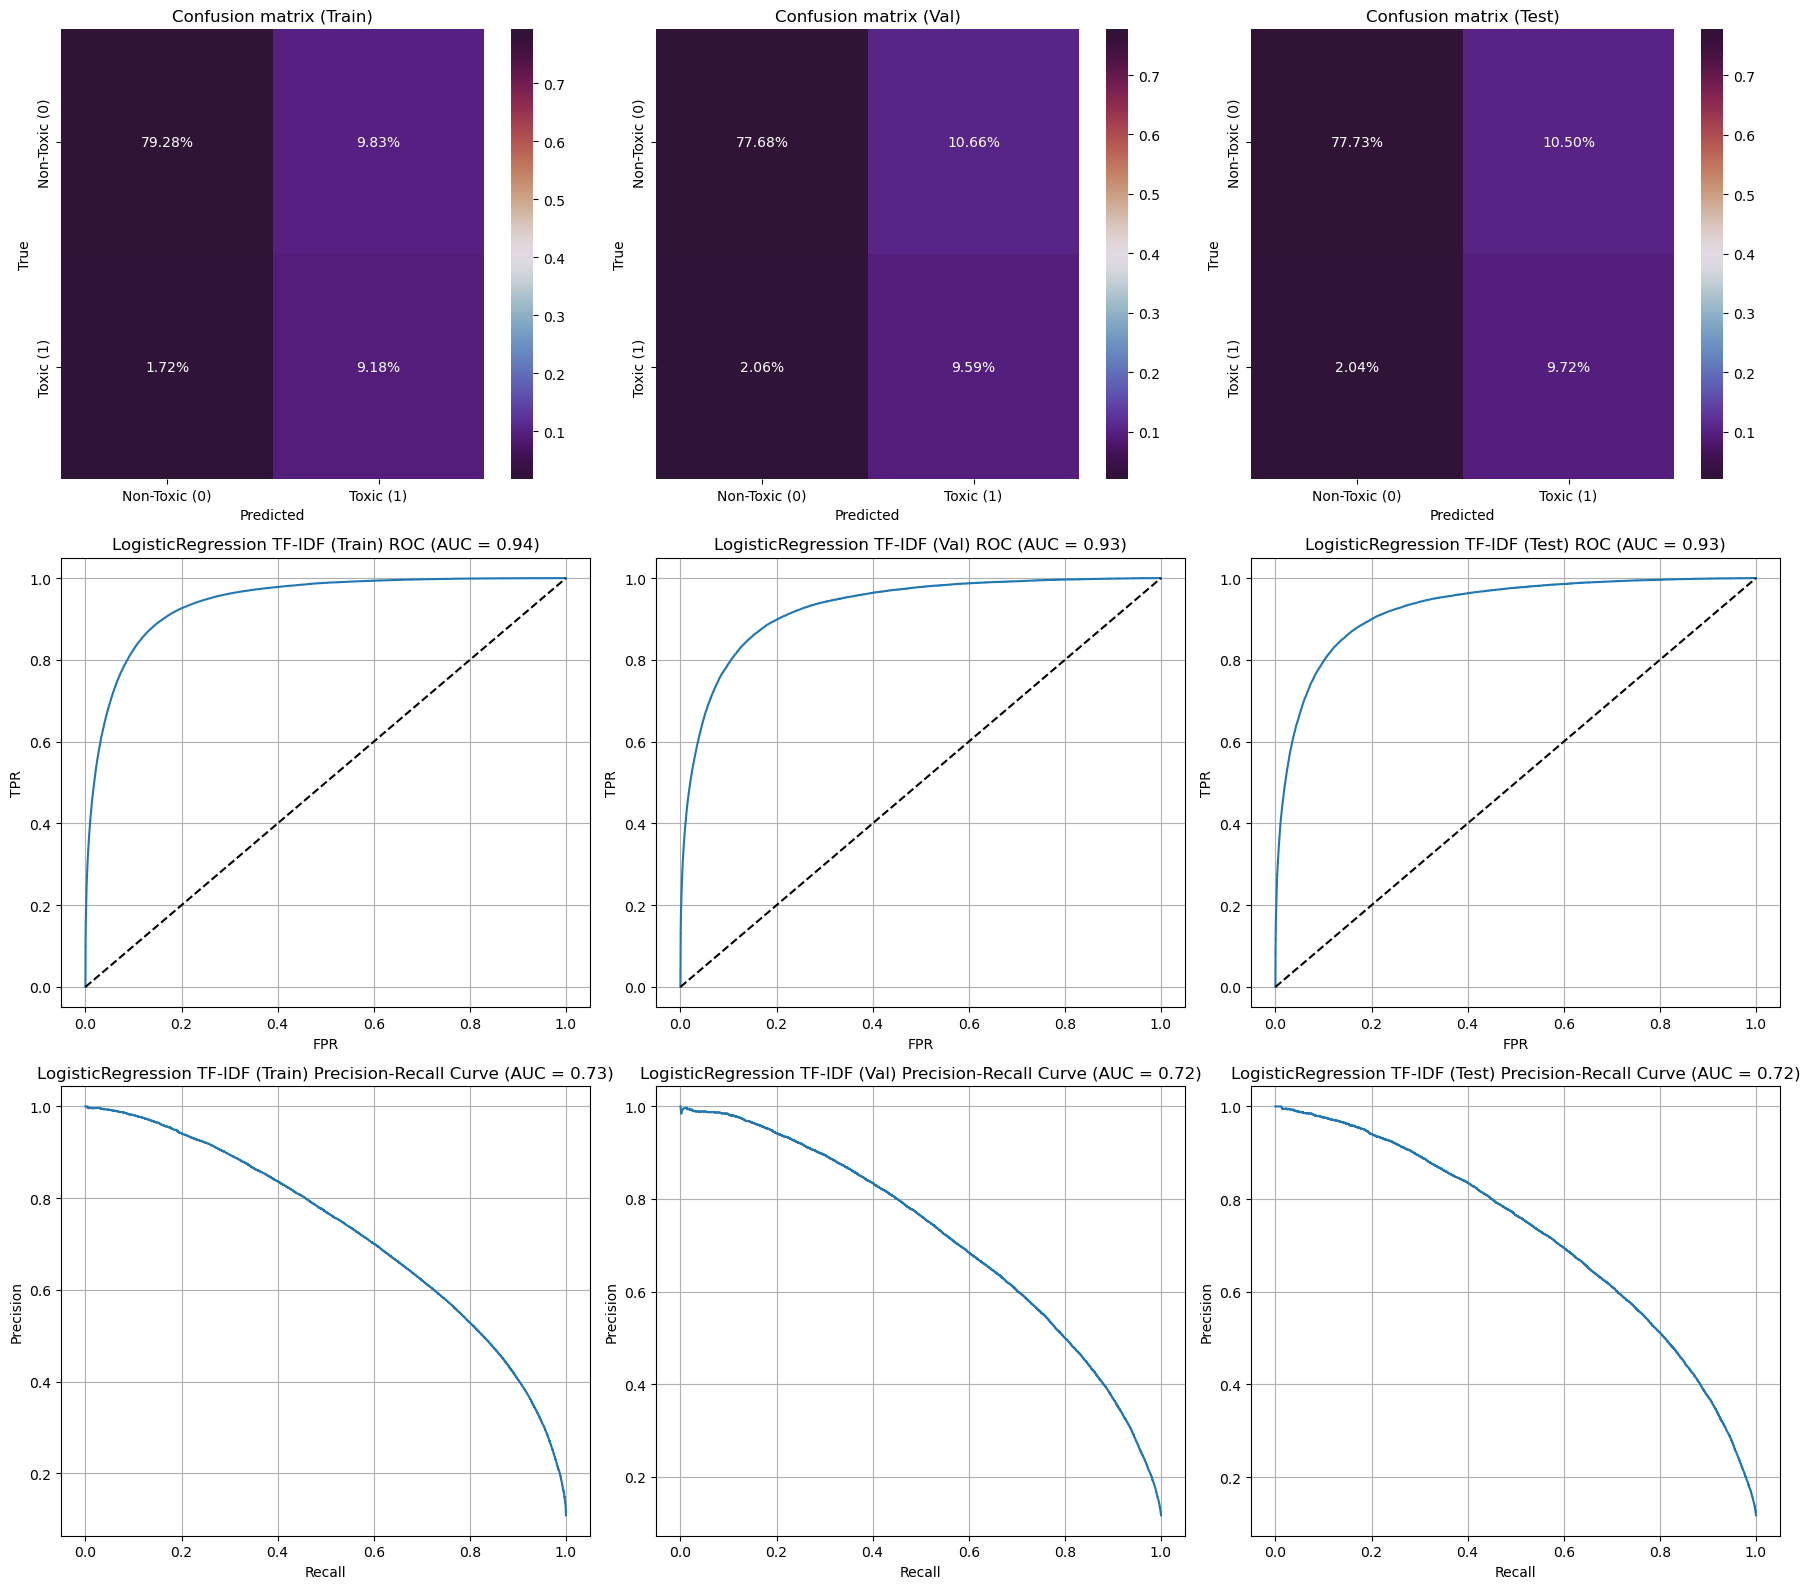

In [140]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_log_reg_tfidf_pred_train,
    y_pred_val=y_log_reg_tfidf_pred_val,
    y_pred_test=y_log_reg_tfidf_pred_test,
    y_pred_proba_train=y_log_reg_tfidf_pred_proba_train,
    y_pred_proba_val=y_log_reg_tfidf_pred_proba_val,
    y_pred_proba_test=y_log_reg_tfidf_pred_proba_test,
    title='LogisticRegression TF-IDF'
)

In [142]:
metrics_data_val = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.01, 1.01, 0.01):
    p = precision_score(y_val, np.where(y_log_reg_tfidf_pred_proba_val > i, 1, 0))
    r = recall_score(y_val, np.where(y_log_reg_tfidf_pred_proba_val > i, 1, 0))
    f = f1_score(y_val, np.where(y_log_reg_tfidf_pred_proba_val > i, 1, 0))
    metrics_data_val.loc[len(metrics_data_val)] = [i, p, r, f]

In [144]:
metrics_data_val[metrics_data_val['f-1'] == metrics_data_val['f-1'].max()]

,threshold,precision,recall,f-1
76,0.770,0.626,0.674,0.649


In [172]:
metrics_data_val[metrics_data_val.threshold == 0.75]

,threshold,precision,recall,f-1
74,0.750,0.614,0.689,0.649


In [146]:
metrics_data_test = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.5, 1.001, 0.001):
    p = precision_score(y_test, np.where(y_log_reg_tfidf_pred_proba_test > i, 1, 0))
    r = recall_score(y_test, np.where(y_log_reg_tfidf_pred_proba_test > i, 1, 0))
    f = f1_score(y_test, np.where(y_log_reg_tfidf_pred_proba_test > i, 1, 0))
    metrics_data_test.loc[len(metrics_data_test)] = [i, p, r, f]

In [174]:
metrics_data_test[metrics_data_test['f-1'] == metrics_data_test['f-1'].max()]

,threshold,precision,recall,f-1
253,0.753,0.620,0.690,0.653


### SVM BoW

In [30]:
from sklearn.calibration import CalibratedClassifierCV

def svc_objective(trial, X_train, X_val, y_train, y_val):
    C = trial.suggest_float('C', 1e-5, 1, log=True)
    penalty = trial.suggest_categorical("penalty", ["l2", "l1"])
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    svc = CalibratedClassifierCV(LinearSVC(C=C, dual=False, penalty = penalty, class_weight=class_weight))
    svc.fit(X_train, y_train)
    
    y_pred_proba = svc.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [32]:
best_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, svc_objective, n_trials=40)
(y_linear_svc_bow_pred_train,
 y_linear_svc_bow_pred_val,
 y_linear_svc_bow_pred_test,
 y_linear_svc_bow_pred_proba_train,
 y_linear_svc_bow_pred_proba_val,
 y_linear_svc_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(**best_params, dual=False)),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-02-23 14:37:51,753] A new study created in memory with name: no-name-19cfdec0-5bfa-49f6-9edd-f0baffc54120
[I 2025-02-23 14:38:22,053] Trial 0 finished with value: 0.6351340842300037 and parameters: {'C': 0.0070277363094770956, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.6351340842300037.
[I 2025-02-23 14:38:27,436] Trial 1 finished with value: 0.5536646296950619 and parameters: {'C': 0.00037561479297587184, 'penalty': 'l1', 'class_weight': None}. Best is trial 0 with value: 0.6351340842300037.
[I 2025-02-23 14:39:27,373] Trial 2 finished with value: 0.6563576774920338 and parameters: {'C': 0.09735051621423968, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6563576774920338.
[I 2025-02-23 14:39:36,307] Trial 3 finished with value: 0.47327673020464434 and parameters: {'C': 4.996106761214429e-05, 'penalty': 'l2', 'class_weight': 'balanced'}. Best is trial 2 with value: 0.6563576774920338.
[I 2025-02-23 14:40:04,006] Tria

SVM BoW

Precision		Recall			F1

Train: 0.82		Train: 0.49		Train: 0.61
Val: 0.76		Val: 0.44		Val: 0.56
Test: 0.77		Test: 0.44		Test: 0.56


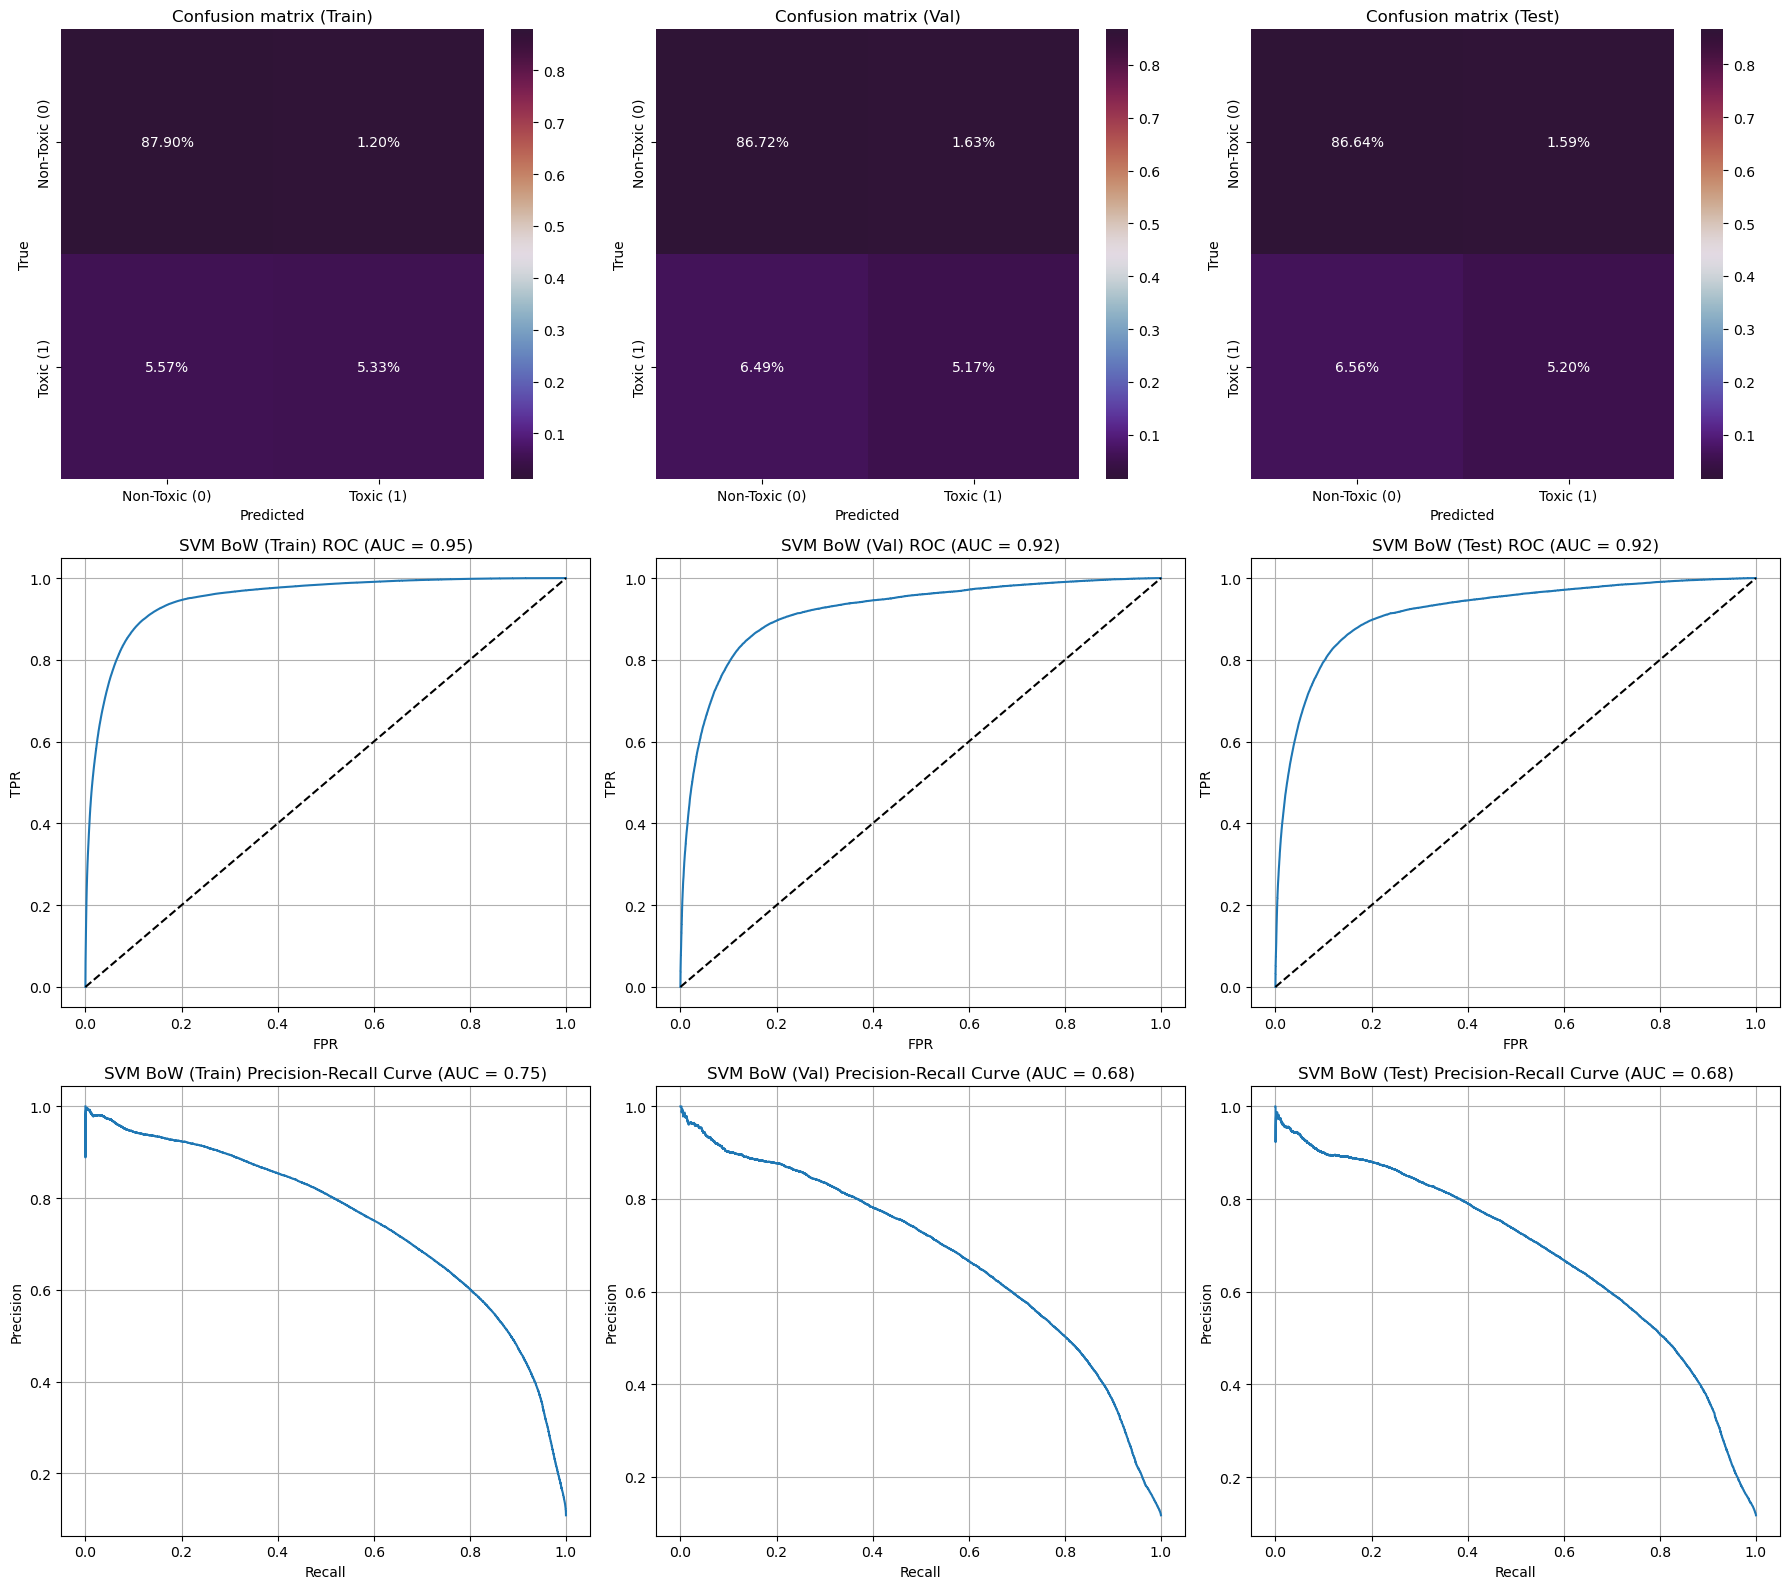

In [34]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_bow_pred_train,
    y_pred_val=y_linear_svc_bow_pred_val,
    y_pred_test=y_linear_svc_bow_pred_test,
    y_pred_proba_train=y_linear_svc_bow_pred_proba_train,
    y_pred_proba_val=y_linear_svc_bow_pred_proba_val,
    y_pred_proba_test=y_linear_svc_bow_pred_proba_test,
    title='SVM BoW'
)

In [40]:
metrics_data_val = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.01, 1.01, 0.01):
    p = precision_score(y_val, np.where(y_linear_svc_bow_pred_proba_val > i, 1, 0))
    r = recall_score(y_val, np.where(y_linear_svc_bow_pred_proba_val > i, 1, 0))
    f = f1_score(y_val, np.where(y_linear_svc_bow_pred_proba_val > i, 1, 0))
    metrics_data_val.loc[len(metrics_data_val)] = [i, p, r, f]

In [41]:
metrics_data_val[metrics_data_val['f-1'] == metrics_data_val['f-1'].max()]

,threshold,precision,recall,f-1
17,0.180,0.605,0.683,0.641


In [44]:
metrics_data_test = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.01, 1.01, 0.01):
    p = precision_score(y_test, np.where(y_linear_svc_bow_pred_proba_test > i, 1, 0))
    r = recall_score(y_test, np.where(y_linear_svc_bow_pred_proba_test > i, 1, 0))
    f = f1_score(y_test, np.where(y_linear_svc_bow_pred_proba_test > i, 1, 0))
    metrics_data_test.loc[len(metrics_data_test)] = [i, p, r, f]

In [45]:
metrics_data_test[metrics_data_test['f-1'] == metrics_data_test['f-1'].max()]

,threshold,precision,recall,f-1
17,0.180,0.611,0.681,0.644


### SVM TF-IDF

In [207]:
#best_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, svc_objective, n_trials=40)
best_params = {'C': 0.2168024965084713, 'penalty': 'l1', 'class_weight': None}
(y_linear_svc_tfidf_pred_train,
 y_linear_svc_tfidf_pred_val,
 y_linear_svc_tfidf_pred_test,
 y_linear_svc_tfidf_pred_proba_train,
 y_linear_svc_tfidf_pred_proba_val,
 y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(**best_params, dual=False)),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-02-19 00:10:33,225] A new study created in memory with name: no-name-1792b21e-96db-44f0-bf6d-fc7ca87c75f3
[I 2025-02-19 00:10:42,353] Trial 0 finished with value: 0.7215012392471001 and parameters: {'C': 0.504422166439523, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.7215012392471001.
[I 2025-02-19 00:10:43,212] Trial 1 finished with value: 0.5582655636813012 and parameters: {'C': 2.617789832358286e-05, 'penalty': 'l1', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.7215012392471001.
[I 2025-02-19 00:10:48,563] Trial 2 finished with value: 0.71681244296981 and parameters: {'C': 0.017205699897823102, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.7215012392471001.
[I 2025-02-19 00:10:52,759] Trial 3 finished with value: 0.6895362088299977 and parameters: {'C': 0.0033202383504604416, 'penalty': 'l2', 'class_weight': None}. Best is trial 0 with value: 0.7215012392471001.
[I 2025-02-19 00:11:06,508] Trial 4 finished with v

In [50]:
best_params = {'C': 0.2168024965084713, 'penalty': 'l1', 'class_weight': None}
(y_linear_svc_tfidf_pred_train,
 y_linear_svc_tfidf_pred_val,
 y_linear_svc_tfidf_pred_test,
 y_linear_svc_tfidf_pred_proba_train,
 y_linear_svc_tfidf_pred_proba_val,
 y_linear_svc_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=CalibratedClassifierCV(LinearSVC(**best_params, dual=False)),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

SVM TF-IDF

Precision		Recall			F1

Train: 0.78		Train: 0.51		Train: 0.61
Val: 0.77		Val: 0.50		Val: 0.61
Test: 0.78		Test: 0.50		Test: 0.61


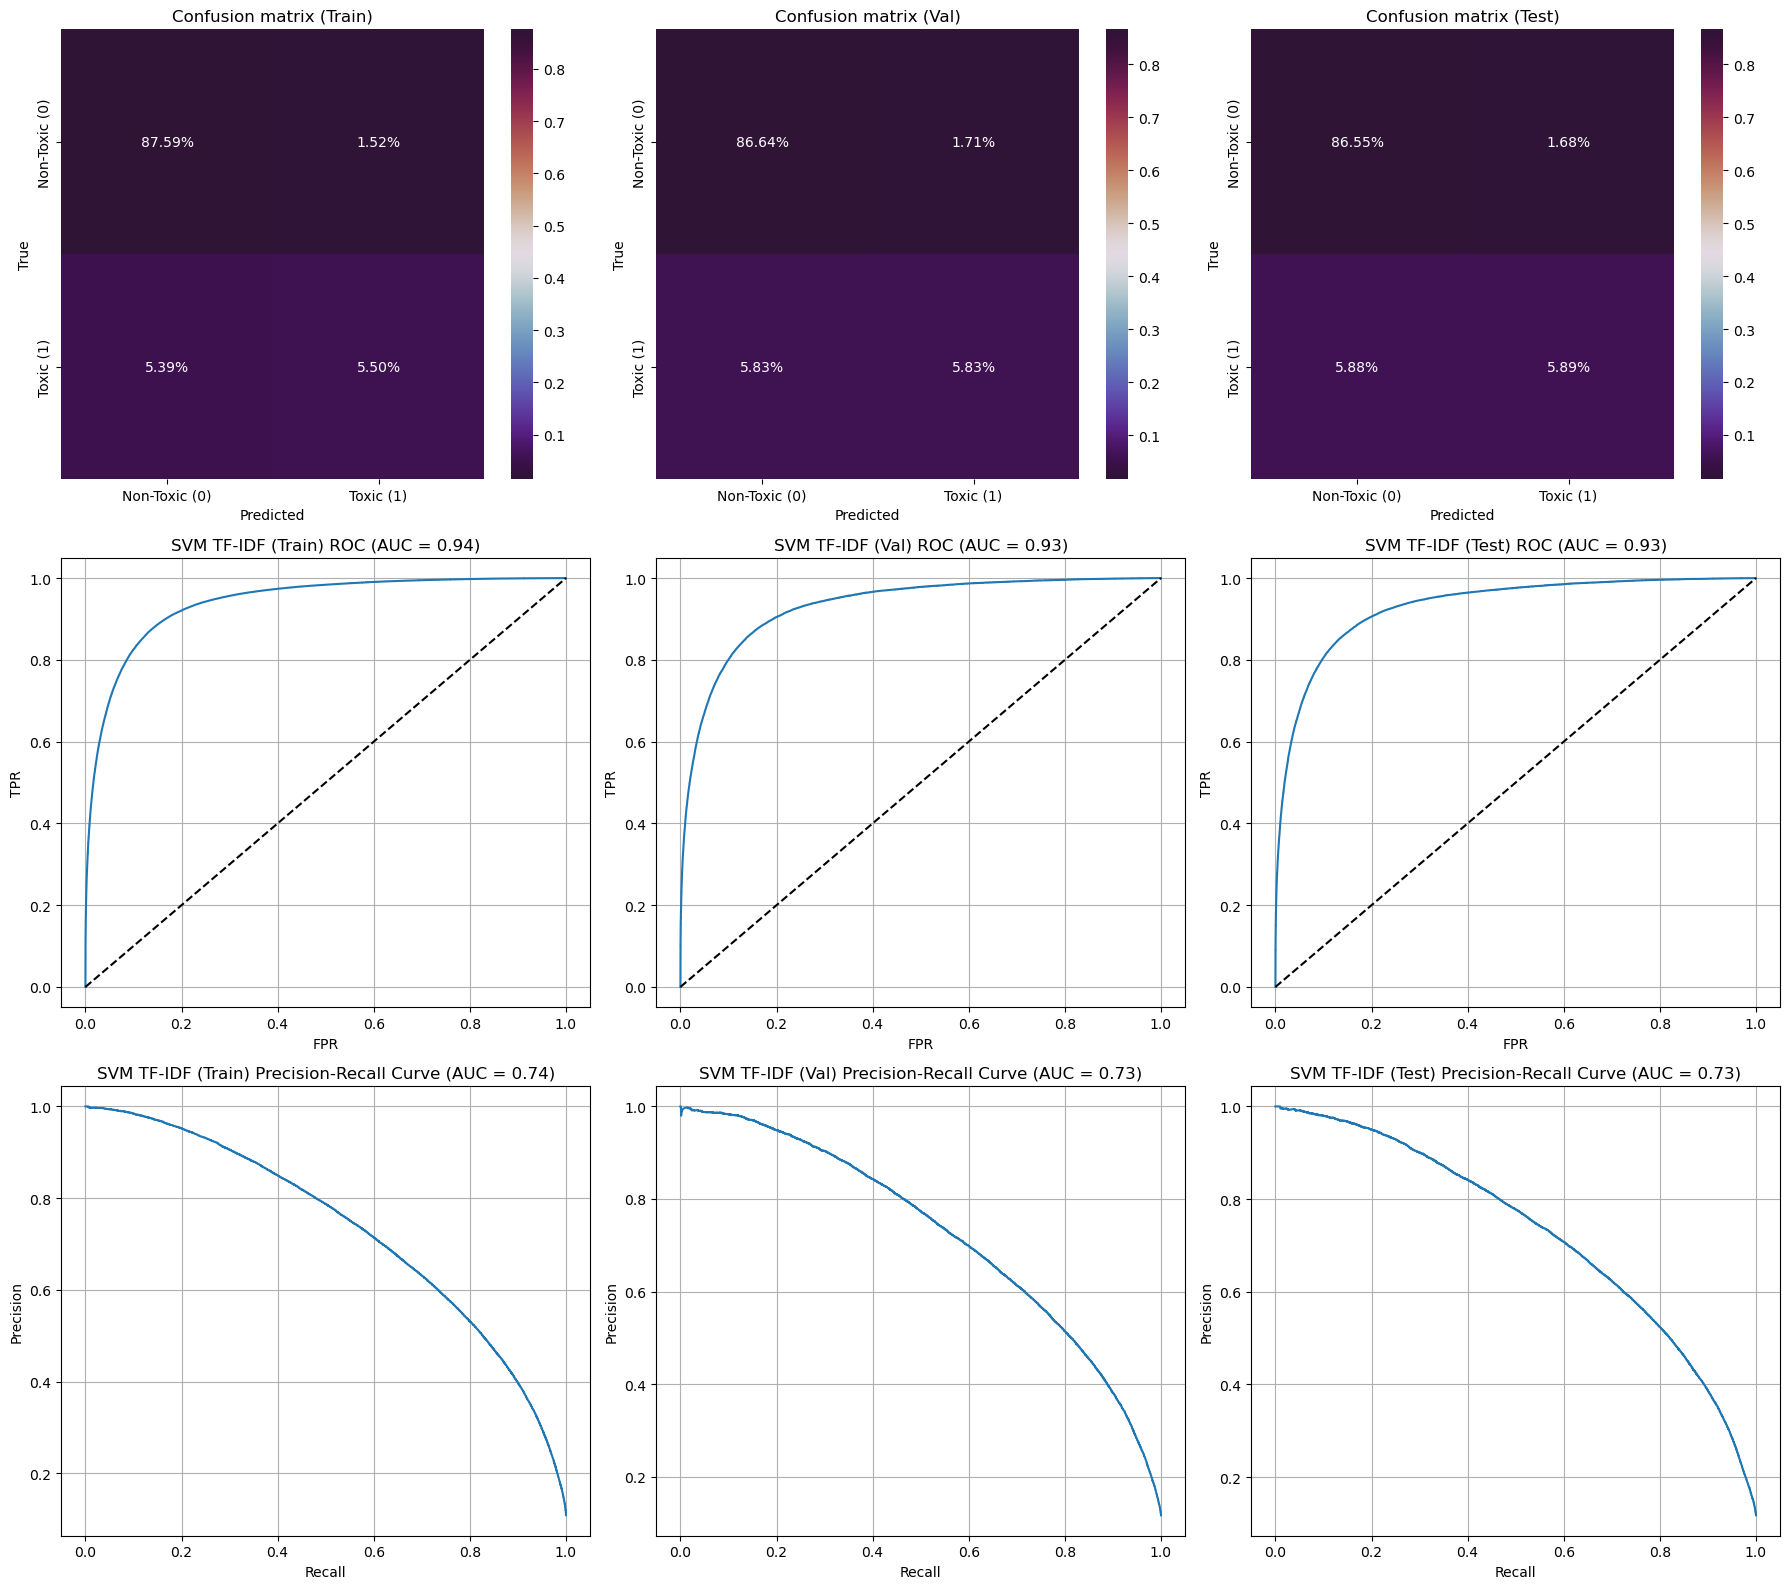

In [51]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_linear_svc_tfidf_pred_train,
    y_pred_val=y_linear_svc_tfidf_pred_val,
    y_pred_test=y_linear_svc_tfidf_pred_test,
    y_pred_proba_train=y_linear_svc_tfidf_pred_proba_train,
    y_pred_proba_val=y_linear_svc_tfidf_pred_proba_val,
    y_pred_proba_test=y_linear_svc_tfidf_pred_proba_test,
    title='SVM TF-IDF'
)

In [56]:
metrics_data_val = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.01, 1.01, 0.01):
    p = precision_score(y_val, np.where(y_linear_svc_tfidf_pred_proba_val > i, 1, 0))
    r = recall_score(y_val, np.where(y_linear_svc_tfidf_pred_proba_val > i, 1, 0))
    f = f1_score(y_val, np.where(y_linear_svc_tfidf_pred_proba_val > i, 1, 0))
    metrics_data_val.loc[len(metrics_data_val)] = [i, p, r, f]

In [57]:
metrics_data_val[metrics_data_val['f-1'] == metrics_data_val['f-1'].max()]

,threshold,precision,recall,f-1
21,0.220,0.627,0.685,0.655


In [58]:
metrics_data_test = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.01, 1.01, 0.01):
    p = precision_score(y_test, np.where(y_linear_svc_tfidf_pred_proba_test > i, 1, 0))
    r = recall_score(y_test, np.where(y_linear_svc_tfidf_pred_proba_test > i, 1, 0))
    f = f1_score(y_test, np.where(y_linear_svc_tfidf_pred_proba_test > i, 1, 0))
    metrics_data_test.loc[len(metrics_data_test)] = [i, p, r, f]

In [59]:
metrics_data_test[metrics_data_test['f-1'] == metrics_data_test['f-1'].max()]

,threshold,precision,recall,f-1
20,0.210,0.627,0.697,0.660


### XGBoost BoW

In [16]:
def xg_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000),
        "max_depth": trial.suggest_int("max_depth", 10, 30),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.2, 0.5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 5),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "random_state": 42,
        "use_label_encoder": False,
        "scale_pos_weight": trial.suggest_int("scale_pos_weight", 1, 10)
    }
    
    model = XGBClassifier(**param)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [ ]:
{'n_estimators': 484, 'max_depth': 20, 'learning _rate': 0.20004669977662015,
 'subsample': 0.8446645954768127, 'colsample_bytree': 0.5244295275638243,
 'gamma': 1.49384015025754, 'min_child_w eight': 6, 'scale_pos_weight': 6}.

In [223]:
best_xg_params = get_hyperparams(X_train_bow, X_val_bow, y_train, y_val, xg_objective, n_trials=30)

(
    y_m1_bow_pred_train,
    y_m1_bow_pred_val,
    y_m1_bow_pred_test,
    y_m1_bow_pred_proba_train,
    y_m1_bow_pred_proba_val,
    y_m1_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(**best_xg_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

[I 2025-02-19 00:35:36,143] A new study created in memory with name: no-name-d8718465-a5c3-4781-8404-ee29cdff3414
[I 2025-02-19 00:38:34,728] Trial 0 finished with value: 0.6731361513184936 and parameters: {'n_estimators': 319, 'max_depth': 21, 'learning_rate': 0.499730860373691, 'subsample': 0.693217490406304, 'colsample_bytree': 0.8421034709142392, 'gamma': 2.5267867354396056, 'min_child_weight': 2, 'scale_pos_weight': 8}. Best is trial 0 with value: 0.6731361513184936.
[I 2025-02-19 00:41:46,141] Trial 1 finished with value: 0.6905041974899654 and parameters: {'n_estimators': 672, 'max_depth': 28, 'learning_rate': 0.34843042029508964, 'subsample': 0.5636883288249429, 'colsample_bytree': 0.6919154375266869, 'gamma': 2.650461818871637, 'min_child_weight': 3, 'scale_pos_weight': 3}. Best is trial 1 with value: 0.6905041974899654.
[I 2025-02-19 00:53:07,632] Trial 2 finished with value: 0.6890187577916481 and parameters: {'n_estimators': 673, 'max_depth': 26, 'learning_rate': 0.28525104

In [64]:
best_xg_params = {'n_estimators': 484, 'max_depth': 20, 'learning_rate': 0.20004669977662015, 'subsample': 0.8446645954768127,
                  'colsample_bytree': 0.5244295275638243, 'gamma': 1.49384015025754, 'min_child_weight': 6, 'scale_pos_weight': 6}

(
    y_m1_bow_pred_train,
    y_m1_bow_pred_val,
    y_m1_bow_pred_test,
    y_m1_bow_pred_proba_train,
    y_m1_bow_pred_proba_val,
    y_m1_bow_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(**best_xg_params),
    X_train=X_train_bow,
    X_val=X_val_bow,
    X_test=X_test_bow,
    y_train=y_train,
)

XGBoost BoW

Precision		Recall			F1

Train: 0.67		Train: 0.87		Train: 0.76
Val: 0.57		Val: 0.73		Val: 0.64
Test: 0.58		Test: 0.73		Test: 0.65


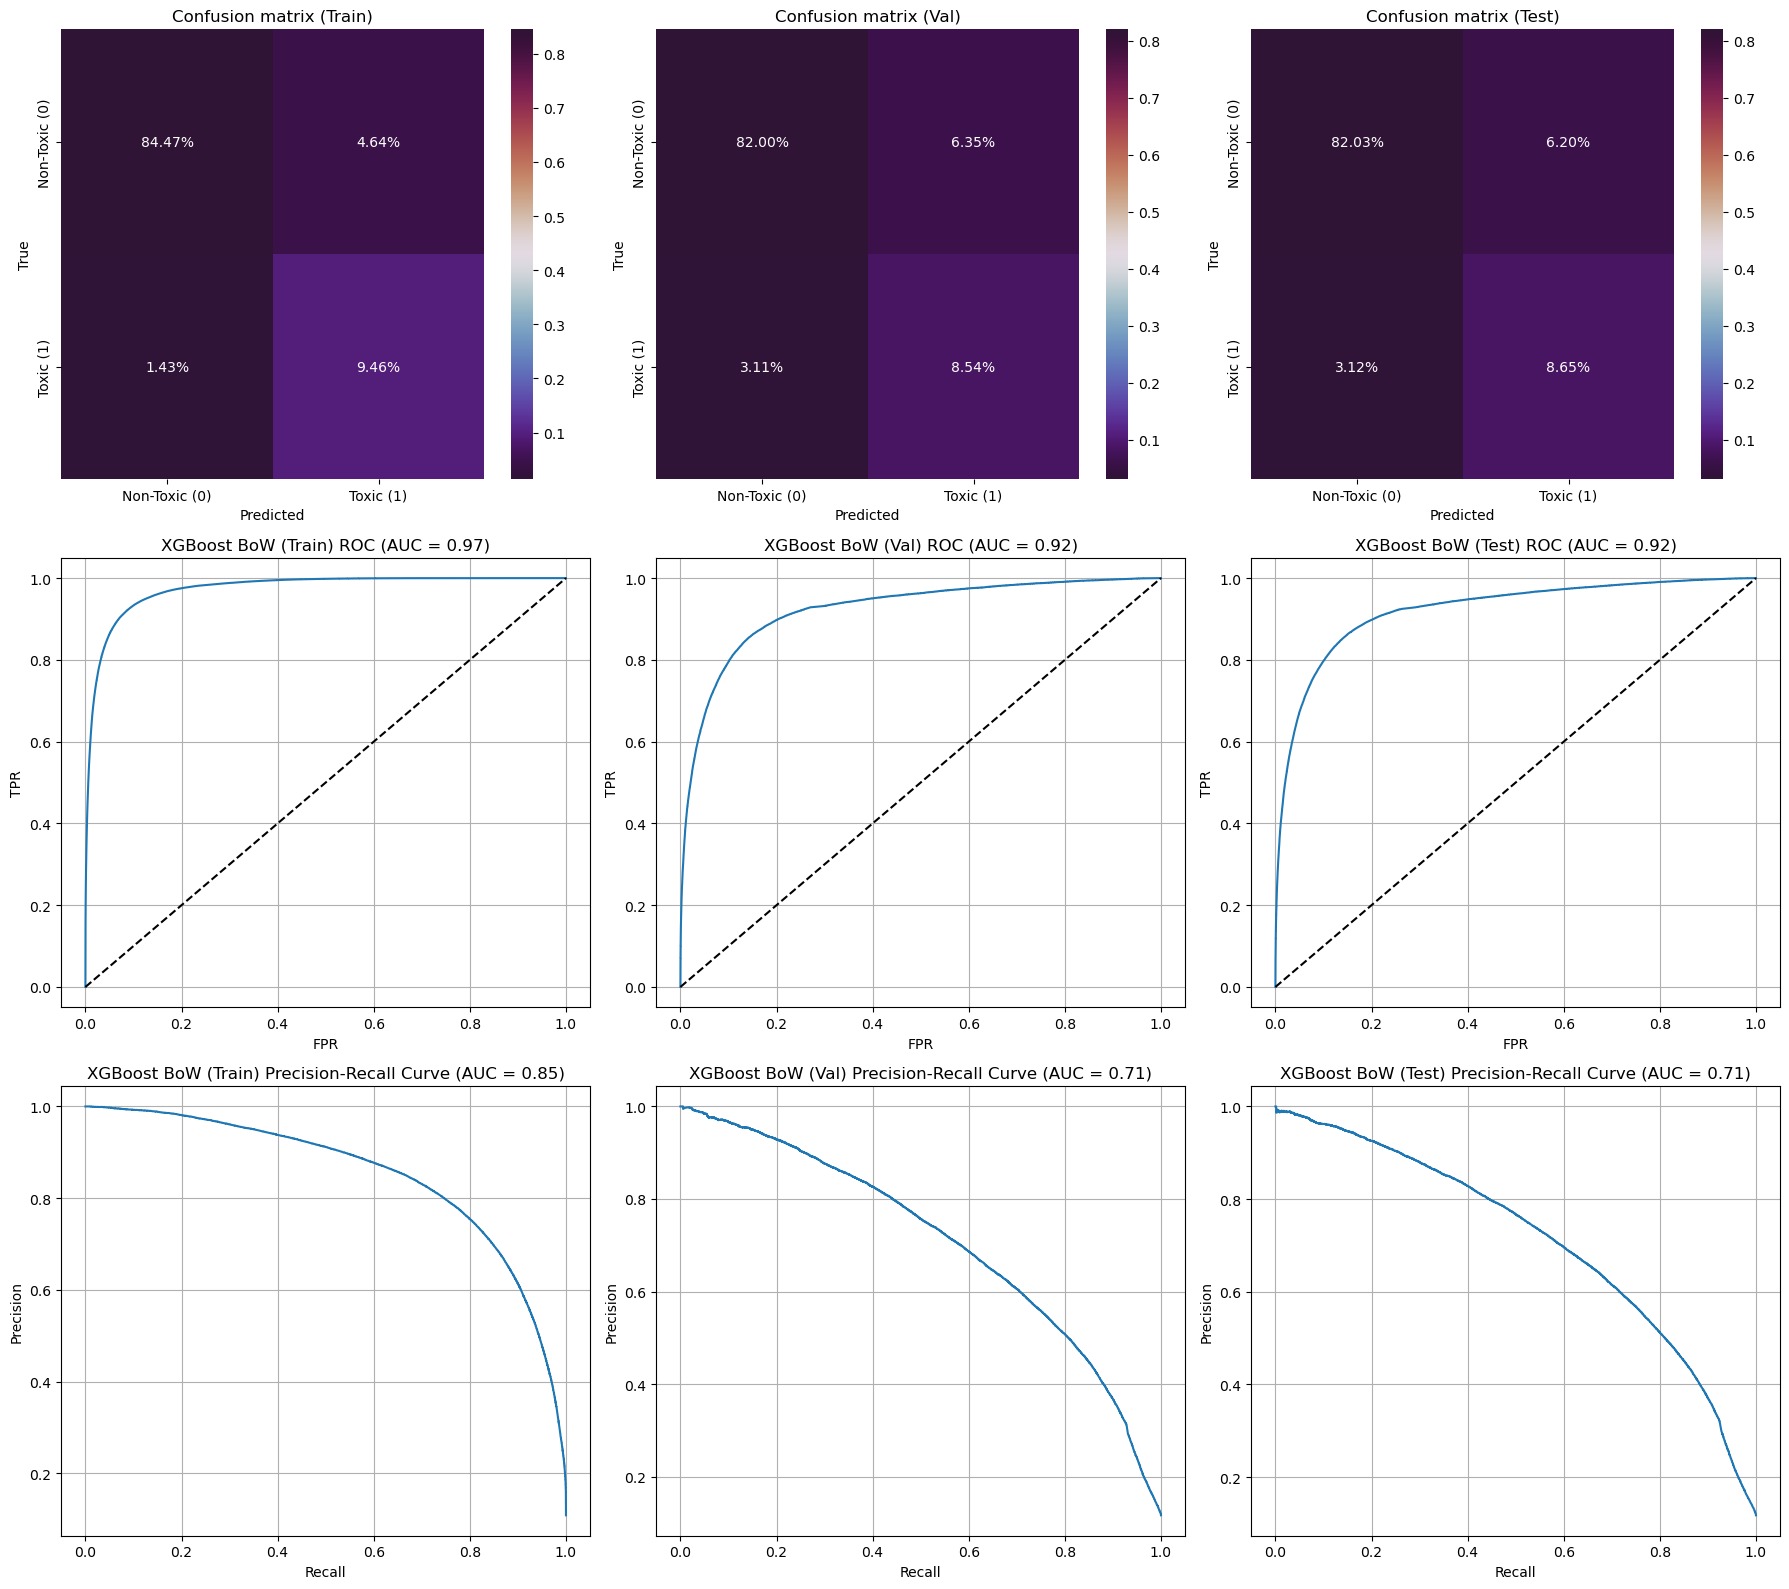

In [65]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_m1_bow_pred_train,
    y_pred_val=y_m1_bow_pred_val,
    y_pred_test=y_m1_bow_pred_test,
    y_pred_proba_train=y_m1_bow_pred_proba_train,
    y_pred_proba_val=y_m1_bow_pred_proba_val,
    y_pred_proba_test=y_m1_bow_pred_proba_test,
    title='XGBoost BoW'
)

In [66]:
metrics_data_val = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0.01, 1.01, 0.01):
    p = precision_score(y_val, np.where(y_m1_bow_pred_proba_val > i, 1, 0))
    r = recall_score(y_val, np.where(y_m1_bow_pred_proba_val > i, 1, 0))
    f = f1_score(y_val, np.where(y_m1_bow_pred_proba_val > i, 1, 0))
    metrics_data_val.loc[len(metrics_data_val)] = [i, p, r, f]

In [67]:
metrics_data_val[metrics_data_val['f-1'] == metrics_data_val['f-1'].max()]

,threshold,precision,recall,f-1
58,0.590,0.624,0.679,0.651


In [68]:
metrics_data_test = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0, 1.01, 0.01):
    p = precision_score(y_test, np.where(y_m1_bow_pred_proba_test > i, 1, 0))
    r = recall_score(y_test, np.where(y_m1_bow_pred_proba_test > i, 1, 0))
    f = f1_score(y_test, np.where(y_m1_bow_pred_proba_test > i, 1, 0))
    metrics_data_test.loc[len(metrics_data_test)] = [i, p, r, f]

In [69]:
metrics_data_test[metrics_data_test['f-1'] == metrics_data_test['f-1'].max()]

,threshold,precision,recall,f-1
60,0.600,0.639,0.676,0.657


### XGBoost TF-IDF

In [22]:
def xg_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        'max_depth': trial.suggest_int('max_depth', 12, 18),  # Меньше глубина, так как данные плотнее
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.1, 0.5),  # Более низкая скорость
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),  # Можно больше, т.к. данные вещественные
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),  # Больше признаков, чем в BoW
        'gamma': trial.suggest_float('gamma', 0, 5),  # Не нужно сильно ограничивать разбиения
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # Можно меньше, так как значения TF-IDF вещественные
        #'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.1, 5),  # Меньше штрафа, чем в BoW
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 5),  # Балансировка классов, но слабее, чем в BoW
        'n_estimators': trial.suggest_int('n_estimators', 200, 1000),
        'random_state': 42
    }
    model = XGBClassifier(**param)

    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_val)[:, 1]

    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)

In [ ]:
def xg_objective(trial, X_train, X_val, y_train, y_val):
    param = {
        'max_depth': trial.suggest_int('max_depth', 14, 18),  # Оптимальный диапазон глубины
        'learning_rate': trial.suggest_float('learning_rate', 0.1, 0.3),  # Оптимизированный шаг обучения
        'subsample': trial.suggest_float('subsample', 0.85, 1.0),  # Высокие значения дали лучший результат
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 0.8),  # Оптимальные значения
        'gamma': trial.suggest_float('gamma', 2, 4),  # Сузили диапазон штрафа на разбиение
        'min_child_weight': trial.suggest_int('min_child_weight', 5, 7),  # Оптимальный диапазон
        'scale_pos_weight': trial.suggest_int('scale_pos_weight', 1, 2),  # Низкие значения дали лучший результат
        'n_estimators': trial.suggest_int('n_estimators', 800, 1000),  # Большее число деревьев улучшает результат
        'random_state': 42
    }
    
    model = XGBClassifier(**param)
    model.fit(X_train, y_train)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, y_pred_proba)
    
    return auc(recall, precision)


In [24]:
best_xg_params = get_hyperparams(X_train_tfidf, X_val_tfidf, y_train, y_val, xg_objective, n_trials=30)

(
    y_m1_tfidf_pred_train,
    y_m1_tfidf_pred_val,
    y_m1_tfidf_pred_test,
    y_m1_tfidf_pred_proba_train,
    y_m1_tfidf_pred_proba_val,
    y_m1_tfidf_pred_proba_test
) = train_and_predict_toxicity(
    model=XGBClassifier(**best_xg_params),
    X_train=X_train_tfidf,
    X_val=X_val_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train,
)

[I 2025-02-20 13:20:58,591] A new study created in memory with name: no-name-428628a3-a193-45b6-b042-4b2d868c0526
[I 2025-02-20 13:30:12,529] Trial 0 finished with value: 0.7169124682264856 and parameters: {'max_depth': 14, 'learning_rate': 0.11365936771302032, 'subsample': 0.7037331993305996, 'colsample_bytree': 0.6111395606819783, 'gamma': 3.1654532862403997, 'min_child_weight': 10, 'scale_pos_weight': 2, 'n_estimators': 426}. Best is trial 0 with value: 0.7169124682264856.
[I 2025-02-20 13:58:47,716] Trial 1 finished with value: 0.7148280547177104 and parameters: {'max_depth': 16, 'learning_rate': 0.21160231534913915, 'subsample': 0.9140817216937385, 'colsample_bytree': 0.5243019997057201, 'gamma': 3.7950141185720305, 'min_child_weight': 2, 'scale_pos_weight': 5, 'n_estimators': 499}. Best is trial 0 with value: 0.7169124682264856.
[I 2025-02-20 14:10:42,459] Trial 2 finished with value: 0.7122531104589296 and parameters: {'max_depth': 12, 'learning_rate': 0.14237465055740395, 'subs

In [ ]:
{'max_depth': 16, 'learning_rate': 0.119567927967194,
 'subsample': 0.902346475891198, 'colsample_bytree': 0.6390555825880484,
 'gamma': 3.4281962700115067, 'min_child_weight': 5, 'scale_pos_weight': 1, 'n_estimators': 951}

In [ ]:
 {'n_estimators': 647, 'max_depth': 12,
  'learning_rate': 0.4249503713694734,
  'subsample': 0.7323854175625921, 'colsample_bytree': 0.5883158203843601,
  'gamma': 0.04756439815469249, 'min_child_weight': 10, 'scale_pos_weight': 1} #0.721

In [ ]:
{'max_depth': 14, 'learning_rate': 0.37525035571077403, 'subsample': 0.779255822856508,
 'colsample_bytree': 0.6962761586016566, 'gamma': 1.8913617127551245, 'min_child_weight': 9,
 'scale_pos_weight': 1, 'n_estimators': 1000}

In [ ]:
{'max_depth': 15, 'learning_rate': 0.1952397241693202,
 'subsample': 0.7356721767323942, 'colsample_bytree': 0.7599356599478724,
 'gamma': 4.705594777194754, 'min_child_weight': 4, 'scale_pos_weight': 2, 'n_estimators': 548}# 0.721

XGBoost TF-IDF

Precision		Recall			F1

Train: 0.87		Train: 0.59		Train: 0.70
Val: 0.78		Val: 0.50		Val: 0.61
Test: 0.78		Test: 0.51		Test: 0.61


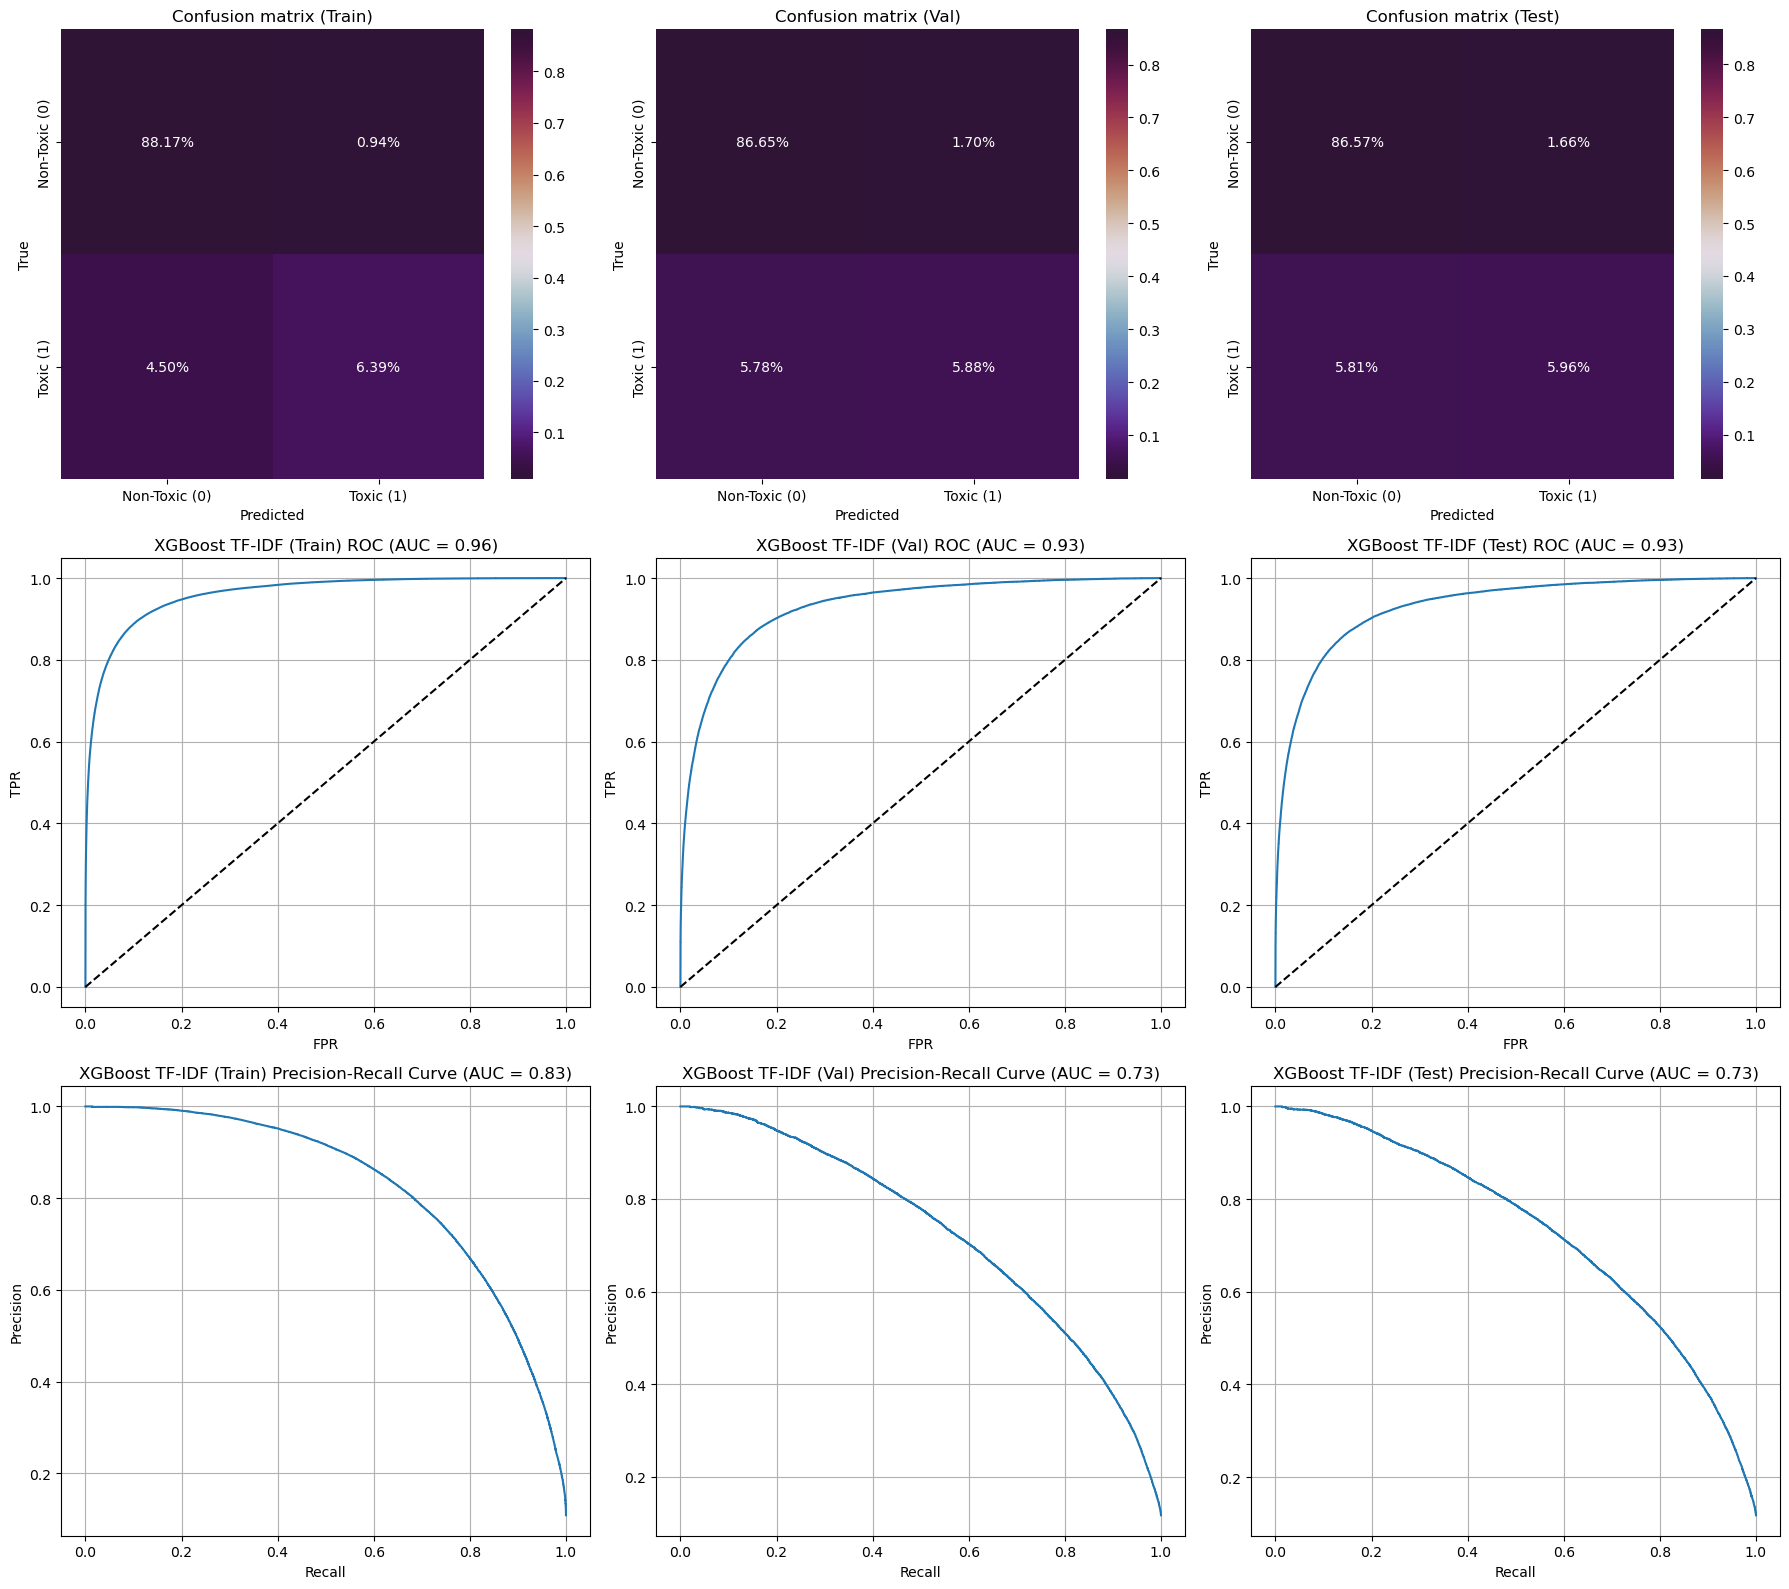

In [25]:
show_metrics(
    y_train=y_train,
    y_val=y_val,
    y_test=y_test,
    y_pred_train=y_m1_tfidf_pred_train,
    y_pred_val=y_m1_tfidf_pred_val,
    y_pred_test=y_m1_tfidf_pred_test,
    y_pred_proba_train=y_m1_tfidf_pred_proba_train,
    y_pred_proba_val=y_m1_tfidf_pred_proba_val,
    y_pred_proba_test=y_m1_tfidf_pred_proba_test,
    title='XGBoost TF-IDF'
)

In [28]:
metrics_data_val = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0, 1, 0.01):
    p = precision_score(y_val, np.where(y_m1_tfidf_pred_proba_val > i, 1, 0))
    r = recall_score(y_val, np.where(y_m1_tfidf_pred_proba_val > i, 1, 0))
    f = f1_score(y_val, np.where(y_m1_tfidf_pred_proba_val > i, 1, 0))
    metrics_data_val.loc[len(metrics_data_val)] = [i, p, r, f]

In [29]:
metrics_data_val[metrics_data_val['f-1'] == metrics_data_val['f-1'].max()]

,threshold,precision,recall,f-1
127,0.270,0.647,0.666,0.656


In [32]:
metrics_data_test = pd.DataFrame(columns = ['threshold','precision', 'recall', 'f-1'])

for i in np.arange(0, 1.01, 0.01):
    p = precision_score(y_test, np.where(y_m1_tfidf_pred_proba_test > i, 1, 0))
    r = recall_score(y_test, np.where(y_m1_tfidf_pred_proba_test > i, 1, 0))
    f = f1_score(y_test, np.where(y_m1_tfidf_pred_proba_test > i, 1, 0))
    metrics_data_test.loc[len(metrics_data_test)] = [i, p, r, f]

In [33]:
metrics_data_test[metrics_data_test['f-1'] == metrics_data_test['f-1'].max()]

,threshold,precision,recall,f-1
24,0.240,0.633,0.694,0.662
